In [3]:
from skimage.io import imread, imsave, imshow
from skimage import img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
import requests
import cv2 #pip install opencv-python
%matplotlib inline

In [6]:
def ColorRecognition(frame, h_min, h_max):
    col1 = 0
    col2 = 0
    row1 = 0
    row2 = 0
    hsv_cam = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    filt_cam = cv2.inRange(hsv_cam, h_min, h_max)
    st1 = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21), (10, 10))
    st2 = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11), (5, 5))
    filt_cam = cv2.morphologyEx(filt_cam, cv2.MORPH_CLOSE, st1)
    filt_cam = cv2.morphologyEx(filt_cam, cv2.MORPH_OPEN, st2)
    filt_cam = cv2.GaussianBlur(filt_cam, (5, 5), 2)
    detect = filt_cam
    row = range(0, detect.shape[0]) #Строки
    col = range(0, detect.shape[1]) #Столбцы
    flag = 0;
    for i in row:
        for j in col:
            if detect[i, j] != flag: #Если цвет пикселя не 0
                row1 = i #Нижняя граница
    for j in col:
        for i in row:
            if detect[i, j] != flag:
                col1 = j #Правая граница
    for i in reversed(row):
        for j in reversed(col):
            if detect[i, j] != flag:
                row2 = i #Верхняя граница
    for j in reversed(col):
        for i in reversed(row):
            if detect[i, j] != flag:
                col2 = j #Левая граница
    cv2.rectangle(frame, (col2, row2), (col1, row1), (255, 0, 0))
    frame = frame.astype('uint8')
    frame = img_as_ubyte(frame)
    objectY = np.round((row1 - 0) / 2) #Ищем центр кадра и центр объекта
    objectX = np.round((col1 - 0) / 2)
    frameY = np.round(frame.shape[0] / 2)
    frameX = np.round(frame.shape[1] / 2)
    deltaX = frameX - objectX #Сдвиг по вертикали(если <0 - вниз, >0 - вверх)
    deltaY = frameY - objectY #Сдвиг по горизонтали(если <0 - вправо, >0 - влево)
    return frame, deltaX, deltaY

In [8]:
#Получение изображения с камеры
cap = cv2.VideoCapture(0)
h_min = (0, 100, 100)
h_max = (20, 255, 255)

while(cap.isOpened()): 
    ret, frame = cap.read()
    if ret:
        ColorRecognition(frame, h_min, h_max)
        cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [113]:
R = frame[:, :, 0]
G = frame[:, :, 1]
B = frame[:, :, 2]
frame1 = np.dstack([B, G, R]) #На кадре с камеры почему-то перепутаны цвета, поэтому преобразуем 

In [114]:
h_min = (0, 100, 100)
h_max = (20, 255, 255)

In [115]:
hsv_cam = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)

In [116]:
filt_cam = cv2.inRange(hsv_cam, h_min, h_max)

In [117]:
st1 = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21), (10, 10)) #Задаем ядро 
st2 = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11), (5, 5))
filt_cam = cv2.morphologyEx(filt_cam, cv2.MORPH_CLOSE, st1)
filt_cam = cv2.morphologyEx(filt_cam, cv2.MORPH_OPEN, st2)

In [118]:
filt_cam = cv2.GaussianBlur(filt_cam, (5, 5), 2)

In [125]:
#Детектирование
detect = filt_cam
row = range(0, detect.shape[0]) #Строки
col = range(0, detect.shape[1]) #Столбцы
pix = np.zeros([detect.shape[0], detect.shape[1]])
flag = 0;
for i in row:
    for j in col:
        if detect[i, j] != flag: #Если цвет пикселя не 0
            row1 = i #Нижняя граница
for j in col:
    for i in row:
        if detect[i, j] != flag:
            col1 = j #Правая граница
for i in reversed(row):
    for j in reversed(col):
        if detect[i, j] != flag:
            row2 = i #Верхняя граница
for j in reversed(col):
    for i in reversed(row):
        if detect[i, j] != flag:
            col2 = j #Левая граница
            
print(row2, col2)
print(row1, col1)

crop = detect[row2:row1, col2:col1]
frame2 = np.ndarray(shape=(frame1.shape[0], frame1.shape[1], 3))

for i in range(0, frame1.shape[0]):
    for j in range(0, frame1.shape[1]):
        frame2[i, j] = frame1[i, j]

if row2 == 0: #Если граница объекта находится на границе кадра - добавляем пару пикселей чтобы было видно все границы
    row2 = row2 + 3
if row1 == 0:
    row1 = row1 - 3
if col1 == 0:
    col1 = col1 - 3
if col2 == 0:
    col2 = col2 + 3

cv2.rectangle(frame2, (col2, row2), (col1, row1), (255, 0, 0))
cv2.rectangle(detect, (col2, row2), (col1, row1), (255))
#for i in range(row2, row1): #Рисуем границы красным цветом
#    for j in range(col2, col1):
#        if (i == row2):
#            frame2[i, j] = (255, 0, 0)
#            detect[i, j] = (255)
#        if (j == col2+2): #Без +-2 почему-то не работает
#            frame2[i, j] = (255, 0, 0)
#            detect[i, j] = (255)
#        if (i == row1-2):
#            frame2[i, j] = (255, 0, 0)
#            detect[i, j] = (255)
#        if (j == col1-2):
#            frame2[i, j] = (255, 0, 0)
#            detect[i, j] = (255)
            
frame2 = frame2.astype('uint8')
frame2 = img_as_ubyte(frame2)

140 278
352 553


In [126]:
#Расчет углов поворота сервоприводов
objectY = np.round((row1 - 0) / 2) #Ищем центр кадра и центр объекта
objectX = np.round((col1 - 0) / 2)
frameY = np.round(frame2.shape[0] / 2)
frameX = np.round(frame2.shape[1] / 2)

print(objectX, objectY)
print(frameX, frameY)

deltaX = frameX - objectX #Сдвиг по вертикали(если <0 - вниз, >0 - вверх)
deltaY = frameY - objectY #Сдвиг по горизонтали(если <0 - вправо, >0 - влево)

print(deltaX, deltaY)

276.0 176.0
320.0 240.0
44.0 64.0


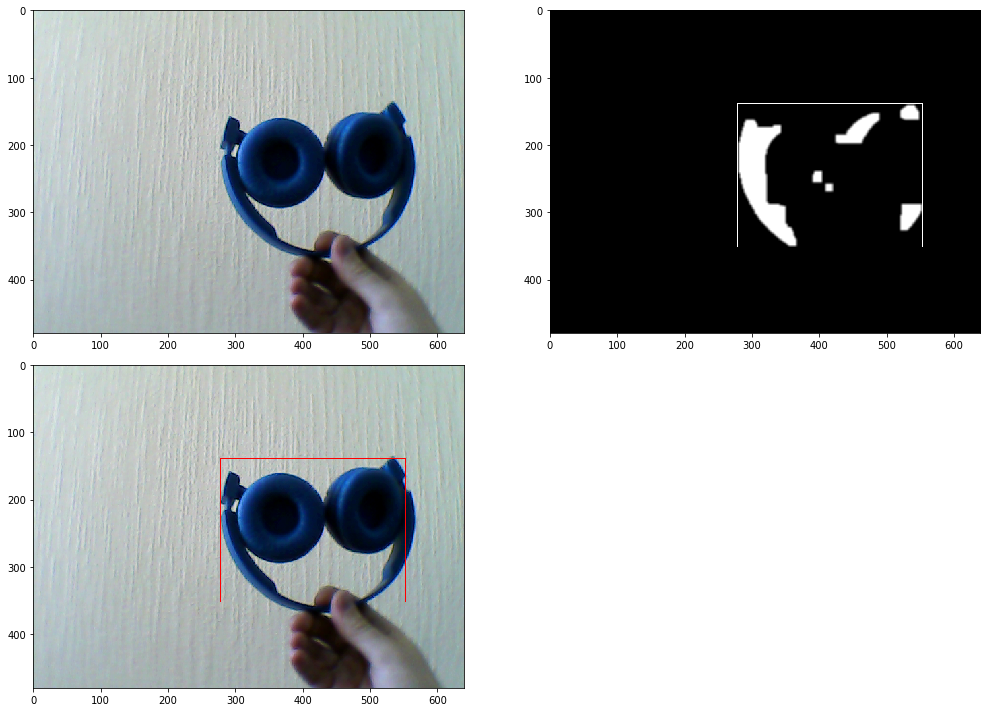

In [127]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
imshow(frame1)
plt.subplot(222)
imshow(filt_cam)
plt.subplot(223)
imshow(frame2)